In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import openpyxl
from openpyxl.drawing.image import Image
import win32com.client as win32
import os

olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column
from Defs import concat_columns

In [161]:
Print_to_excel = True

In [186]:
# получается даже так:
# 10/23 - 03/24
# 07/23 - 03/24
# 04/23 - 03/24
date_1 = '01/04/23'
date_2 = '01/03/24'
query = f"""
select NVL("HOLDING",'Empty') as HOLDING, NVL("BUSINESS_UNIT",'Empty') as BUSINESS_UNIT, NVL("DOC_DATE",TO_DATE('01/01/22', 'DD/MM/YY')) as DOC_DATE, NVL("FIN_POSITION_NAME",'Empty') as FIN_POSITION_NAME, NVL("REP_GROUP",'Empty') as REP_GROUP, NVL("CP_GROUP_FLAG",0) as CP_GROUP_FLAG,  SUM(NVL("AMOUNT_USD",0)) as AMOUNT_USD 
from "RISKCUSTOM"."DDS_DAILY_DETAIL"
where DOC_DATE between TO_DATE('{date_1}', 'DD/MM/YY') and TO_DATE('{date_2}', 'DD/MM/YY')
and CP_GROUP_FLAG <> 1
and AMOUNT < 0 
and REP_GROUP not in ('debt repayment', 'intragroup loans', 'cash pooling')
GROUP BY "HOLDING", "BUSINESS_UNIT", "DOC_DATE", "FIN_POSITION_NAME", "REP_GROUP", "CP_GROUP_FLAG"
"""

data = export_from_RISKCUSTOM(query)
# "select NVL(""HOLDING"",'Empty') as HOLDING, NVL(""BUSINESS_UNIT"",'Empty') as BUSINESS_UNIT, NVL(""DOC_DATE"",TO_DATE('01/01/22', 'DD/MM/YY')) as DOC_DATE, NVL(""FIN_POSITION_NAME"",'Empty') as FIN_POSITION_NAME, NVL(""REP_GROUP"",'Empty') as REP_GROUP, NVL(""CP_GROUP_FLAG"",0) as CP_GROUP_FLAG,  SUM(NVL(""AMOUNT_USD"",0)) as AMOUNT_USD from ""RISKCUSTOM"".""DDS_DAILY_DETAIL""
# where HOLDING = 'SUEK'
# --and CP_GROUP_FLAG <> 1
# --and AMOUNT < 0 
# --and BUSINESS_UNIT = 'W100' --and REP_GROUP is not NULL
# --and REP_GROUP = 'other'
# and DOC_DATE between TO_DATE('01/01/22', 'DD/MM/YY') and TO_DATE('28/03/23', 'DD/MM/YY')
# GROUP BY ""HOLDING"", ""BUSINESS_UNIT"", ""DOC_DATE"", ""FIN_POSITION_NAME"", ""REP_GROUP"", ""CP_GROUP_FLAG"""


C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['SGC' 'SGC' 'SGC' ... 'SGC' 'SGC' 'NTC']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merge_data.loc[merge_data[f'{id_col}_merge'] != 'External', 'last_merge'] = merge_data.loc[merge_data[f'{id_col}_merge'] != 'External', f'{id_col}_merge']
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other

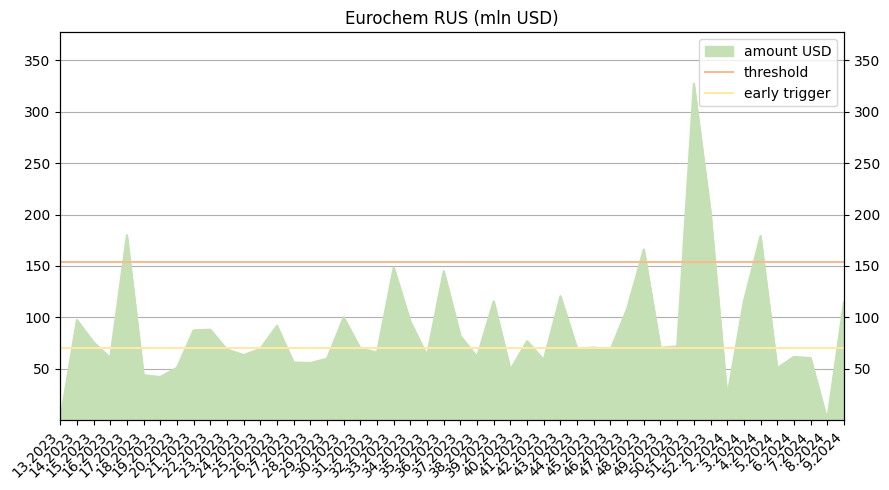

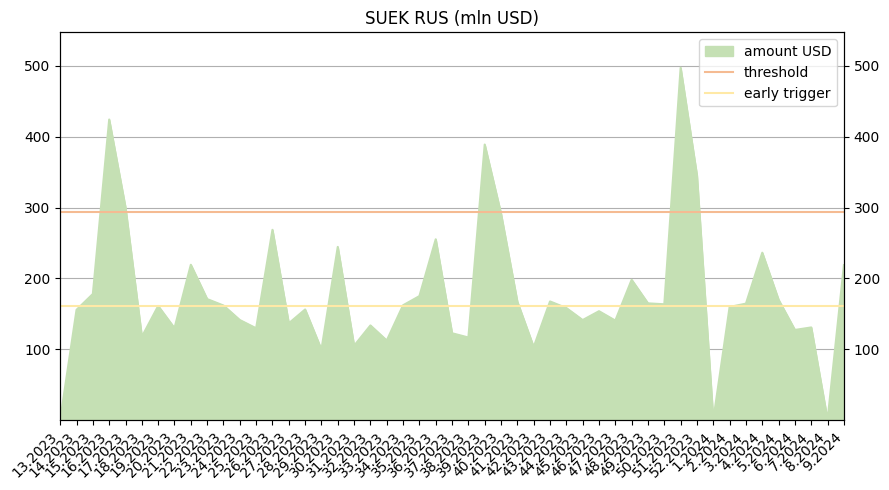

In [187]:
# Создание списка для проверки по полю FIN_POSITION_NAME
files_list = [x for x in os.listdir() if 'export' in x]
data_excel_SUEK = pd.read_excel(files_list[1], sheet_name='sales and exclusions')
data_excel_Ech = pd.read_excel(files_list[0], sheet_name='sales and exclusions')
leaving_data_concat = pd.concat([data_excel_Ech.iloc[:, 3], data_excel_SUEK.iloc[:, 3]], axis=0).dropna()
leaving_list = leaving_data_concat.values.tolist()
# Фиотрация на исходящих и долговых операций
data_work = data[~data.FIN_POSITION_NAME.isin(leaving_list)].reset_index(drop=True)
# merge
data_work['business_segment'] = merge_SalesUnits(data_work, col='BUSINESS_UNIT', merge_col='ocpSegment', id_col='sapId')
data_work['country'] = merge_SalesUnits(data_work, col='BUSINESS_UNIT', merge_col='registryCountry', id_col='sapId')
# фильтр на Росиию
data_work = data_work[data_work['country'] == 'RU'].reset_index(drop=True)
# week num
data_work['week'] = data_work.DOC_DATE.apply(lambda x:x.isocalendar()[1])
data_work['year'] = data_work.DOC_DATE.dt.year
data_work['week_num'] = data_work['week'].astype(str) + '.' +data_work['year'].astype(str)
# group bu weeks
data_work_week_group = data_work.groupby(['HOLDING', 'year','week', 'week_num'], as_index=False).agg({'AMOUNT_USD':'sum'}).rename(columns={'AMOUNT_USD':'sum_amount_mln'})
data_work_week_group.sum_amount_mln = data_work_week_group.sum_amount_mln.abs() / 10**6
# group by holding
data_work_hold_group = pd.pivot_table(data=data_work_week_group, index='HOLDING', values='sum_amount_mln', aggfunc=[lambda x: x.quantile(0.9), 'median']).reset_index()
data_work_hold_group.columns = ['holding', '90th_quantile', 'median']

# графики
for group in data_work_week_group.HOLDING.unique().tolist():
    data_plot = data_work_week_group[data_work_week_group.HOLDING == group]
    fig, ax = plt.subplots(figsize=(9, 5)) # размер графика
    # Построение фигур и линий
    ax.plot(data_plot.week_num, data_plot.sum_amount_mln, color='#c5e0b4')
    ax.fill_between(data_plot.week_num, data_plot.sum_amount_mln, color='#c5e0b4', label='amount USD')
    y_90th = data_work_hold_group.loc[data_work_hold_group.holding == group, '90th_quantile'].values.tolist()[0]
    ax.axline((0, y_90th), (1, y_90th), color='#f5bb92', label='threshold')
    y_median = data_work_hold_group.loc[data_work_hold_group.holding == group, 'median'].values.tolist()[0]
    ax.axline((0, y_median), (1, y_median), color='#ffe9a6', label='early trigger')
    ax.legend(loc='upper right')
    # сетка
    ax.grid(axis='y') 
    ax.set_axisbelow(True)
    # растянуть график по x
    xmin, xmax = data_plot.week_num.min(), data_plot.week_num.max() 
    ax.set_xlim([xmin, xmax])
    # растянуть график по y
    ymin, ymax = data_plot.sum_amount_mln.min(), data_plot.sum_amount_mln.max() + 50
    ax.set_ylim([ymin, ymax]) 
    ax.twinx().set_ylim(ymin, ymax) # добавить вторую ось y
    plt.title(f'{group} RUS (mln USD)') # название графика
    # Каждая n-ый день недели в качестве делелния на оси 
    xticks = data_plot.week_num
    plt.xticks(xticks, rotation=45, ha="right")
    xticks_labels = data_plot.week_num.astype(str).tolist()
    ax.set_xticklabels(xticks_labels, rotation=45, ha="right" )

    plt.tight_layout()
    plt.savefig(f'{group}_triggers.png')

# Запись в файл:
date_1_print = date_1[3:].replace('/','.')
date_2_print = date_2[3:].replace('/','.')
today = str(date.today())
Output_file = today + '_triggers.xlsx'
if Print_to_excel == True:
    sheet_name = f'{date_1_print} to {date_2_print}'
    if Output_file in os.listdir():
        new_list(data_work_hold_group, Output_file, sheet_name=sheet_name)
    else:
        data_work_hold_group.to_excel(Output_file, index=False, sheet_name=sheet_name)
    # Create a new or open existing Excel file with openpyxl
    wb = openpyxl.load_workbook(Output_file)  # Open existing or create new
    ws = wb[sheet_name]
    # Error handling: Check if image file exists
    count = 2
    for image in [x for x in os.listdir() if 'triggers.png' in x]:
        try:
            img = Image(image)
        except FileNotFoundError:
            print(f"Error: Image file '{image}' not found. Skipping image insertion.")
            img = None  # Set img to None to avoid potential errors
        # Insert image if it exists
        if img:
            img.anchor = f'D{count}'  # Adjust cell reference as needed
            ws.add_image(img)
            count = 30
    # Save the Excel file (overwrite if existing)
    wb.save(Output_file)

In [111]:
# Проверка на merge
data_work.loc[data_work.business_segment == 'External', ['HOLDING', 'BUSINESS_UNIT']].drop_duplicates()
data_work.loc[data_work.country == 'External', ['HOLDING', 'country']].drop_duplicates()

array(['RU', 'AE', 'CH', 'DE', 'LT', 'US', 'CY', 'CN', 'KR', 'TW', 'AR',
       'EE', 'External', 'MD', 'VN', 'PL', 'BY'], dtype=object)